<a href="https://colab.research.google.com/github/Alex-Bernal27/Colab/blob/main/Tarea_3_RNN_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificacion de texto Redes Neuronal Recurrente


In [ ]:
!pip install -q -U tensorflow
!pip install -q tensorflow_datasets

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
tfds.disable_progress_bar()

In [ ]:
#El conjunto de datos de reseñas de películas grandes de IMDB es un conjunto de datos de clasificación binaria: 
#todas las reseñas tienen un sentimiento positivo o negativo. 
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

## Pre-proceso

In [ ]:
#Devuelve un conjunto de datos de (texto, etiquetas): 
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
#Mezcle los datos para el entrenamiento y cree lotes de estos pares (texto, etiqueta) 
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Like some of the other folks who have reviewed this film, I was also waxing nostalgic about it...before I had the misfortune to actually watch it again. Alas, my childhood memories of this film were completely untrustworthy, and The Perils of Pauline is now revealed to be an embarrassing exercise in banal, racist, and plain boring film-making. Even the presence of old pros Edward Everett Horton and Terry-Thomas can't overcome a rancid screenplay, a horrible theme song, and some wretched 'special effects'. In addition, the stereotypical depictions of African and Arab characters make for painful viewing, especially considering this was produced in the immediate wake of the Civil Rights movement. Michael Weldon's original Psychotronic Encyclopedia reports that The Perils of Pauline was originally produced for television but inexplicably ended up getting a theatrical release. Judging from the results, that is a completely believable (and baffling) scenario."
 b'When a rich tycoo

In [ ]:
#El texto sin formato cargado por tfds debe procesarse antes de que pueda usarse en un modelo. 
#La forma más sencilla de procesar texto para entrenamiento es usar la capa experimental.preprocessing.TextVectorization. 
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
#El método .adapt establece el vocabulario de la capa. 
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
#Aquí están las primeras 20 fichas. Después del relleno y los tokens desconocidos, se ordenan por frecuencia
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
#Una vez que se establece el vocabulario, la capa puede codificar texto en índices. 
#Los tensores de los índices se rellenan con 0 en la secuencia más larga del lote 
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[39, 47,  5, ...,  0,  0,  0],
       [51,  4,  1, ...,  0,  0,  0],
       [ 4,  1,  5, ...,  0,  0,  0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Like some of the other folks who have reviewed this film, I was also waxing nostalgic about it...before I had the misfortune to actually watch it again. Alas, my childhood memories of this film were completely untrustworthy, and The Perils of Pauline is now revealed to be an embarrassing exercise in banal, racist, and plain boring film-making. Even the presence of old pros Edward Everett Horton and Terry-Thomas can't overcome a rancid screenplay, a horrible theme song, and some wretched 'special effects'. In addition, the stereotypical depictions of African and Arab characters make for painful viewing, especially considering this was produced in the immediate wake of the Civil Rights movement. Michael Weldon's original Psychotronic Encyclopedia reports that The Perils of Pauline was originally produced for television but inexplicably ended up getting a theatrical release. Judging from the results, that is a completely believable (and baffling) scenario."
Round-trip:  like 

## Crear el modelo

1. La primera capa es el "codificador", que convierte el texto en una secuencia de índices de tokens.
2. Embeddings almacena un vector por palabra. Cuando se llama, convierte las secuencias de índices de palabras en secuencias de vectores. Estos vectores se pueden entrenar. Después del entrenamiento (con suficientes datos), las palabras con significados similares a menudo tienen vectores similares.
3. Una red neuronal recurrente procesa la entrada de secuencia iterando a través de los elementos. Los RNN pasan las salidas de un paso de tiempo a su entrada en el siguiente paso de tiempo.

  El contenedor `tf.keras.layers.Bidirectional` también se puede utilizar con una capa RNN. Esto propaga la entrada hacia adelante y hacia atrás a través de la capa RNN y luego concatena la salida final.

  * La principal ventaja de un RNN bidireccional es que la señal desde el principio de la entrada no necesita procesarse hasta el final en cada paso de tiempo para afectar la salida.

  * La principal desventaja de un RNN bidireccional es que no puede transmitir predicciones de manera eficiente a medida que se agregan palabras al final.

1. Una vez que el RNN ha convertido la secuencia en un solo vector, las dos "capas. Densas" realizan un procesamiento final y convierten esta representación vectorial en un solo logit como resultado de la clasificación. 

![A drawing of the information flow in the model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/bidirectional.png?raw=1)

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Utilice enmascaramiento para manejar las longitudes de secuencia variable 
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
#La capa de incrustación usa enmascaramiento para manejar las diferentes longitudes de secuencia. Todas las capas después del enmascaramiento de soporte de incrustación 
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


## Entrenar el modelo

In [ ]:
#Compile el modelo de Keras para configurar el proceso de entrenamiento
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 34s 86ms/step - loss: 0.5915 - accuracy: 0.6244 - val_loss: 0.4641 - val_accuracy: 0.7536
Epoch 2/10
391/391 [==============================] - 33s 83ms/step - loss: 0.3879 - accuracy: 0.8270 - val_loss: 0.3675 - val_accuracy: 0.8448
Epoch 3/10
391/391 [==============================] - 33s 84ms/step - loss: 0.3410 - accuracy: 0.8532 - val_loss: 0.3769 - val_accuracy: 0.8453
Epoch 4/10
391/391 [==============================] - 33s 83ms/step - loss: 0.3221 - accuracy: 0.8617 - val_loss: 0.3332 - val_accuracy: 0.8557
Epoch 5/10
391/391 [==============================] - 33s 83ms/step - loss: 0.3124 - accuracy: 0.8678 - val_loss: 0.3292 - val_accuracy: 0.8531
Epoch 6/10
391/391 [==============================] - 32s 82ms/step - loss: 0.3078 - accuracy: 0.8703 - val_loss: 0.3274 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 33s 84ms/step - loss: 0.3047 - accuracy: 0.8712 - val_loss: 0.3221 - val_accuracy:

## Analisis de rendimiento

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 21s 41ms/step - loss: 0.6932 - accuracy: 0.5021
Test Loss: 0.6931421160697937
Test Accuracy: 0.5


(0.0, 0.6063143149018287)

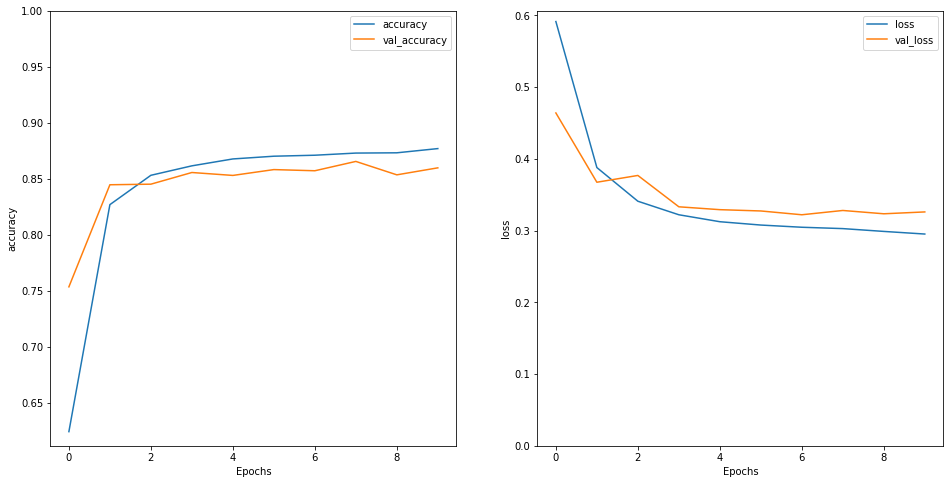

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [ ]:
#Ejecuta una predicción en una nueva oración:
#Si la predicción es> = 0.0, es positiva, de lo contrario es negativa. 
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

array([[0.79729176]], dtype=float32)